# Linear Model Explainability

Here we would like to demo how to use ELI5 library to exam the feature attribution of a linear model (Logistic regression). I borrowed most of the code from [here](https://github.com/klemag/pydata_nyc2018-intro-to-model-interpretability/blob/master/Introduction%20to%20Model%20Interpretability.ipynb). You can also watch the presentation video [here](https://www.youtube.com/watch?v=C80SQe16Rao&t=989s).

The dataset here we are using are from [here](https://archive.ics.uci.edu/ml/datasets/bank+marketing). The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

**Features Meaning:**

#bank client data:

1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7- loan: has personal loan? (categorical: 'no','yes','unknown')

#related with the last contact of the current campaign:

8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

#other attributes:

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

#social and economic context attributes

16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)

17 - cons.price.idx: consumer price index - monthly indicator (numeric)

18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)

19 - euribor3m: euribor 3 month rate - daily indicator (numeric)

20 - nr.employed: number of employees - quarterly indicator (numeric)

In [16]:
# Loading the library
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

from sklearn.linear_model import LogisticRegression


In [17]:
# Loading the data
df = pd.read_csv("data/bank-additional-full.csv", sep=";")
df.y.value_counts()

# Get X, y
y = df["y"].map({"no":0, "yes":1})
X = df.drop("y", axis=1)
X.drop("duration", inplace=True, axis=1)
X.dtypes

# Some such as default would be binary features, but since
# they have a third class "unknown" we'll process them as non binary categorical
num_features = ["age", "campaign", "pdays", "previous", "emp.var.rate", 
                "cons.price.idx", "cons.conf.idx","euribor3m", "nr.employed"]

cat_features = ["job", "marital", "education","default", "housing", "loan",
                "contact", "month", "day_of_week", "poutcome"]

preprocessor = ColumnTransformer([
    ("numerical", "passthrough", num_features), 
    ("categorical", OneHotEncoder(sparse=False, handle_unknown="ignore"), cat_features)])

In [18]:
# Logistic Regression
lr_model = Pipeline(
    [("preprocessor", preprocessor), 
     ("model", LogisticRegression(class_weight="balanced", solver="liblinear", random_state=42))
    ]
)

In [19]:
# Split the train and test dataset
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify=y,
    test_size=.3,
    random_state=42
)


In [21]:
# grid search for the best 
gs = GridSearchCV(lr_model, {"model__C": [1, 1.3, 1.5]}, n_jobs=-1, cv=5, scoring="accuracy")
_ = gs.fit(X_train, y_train)

In [22]:
# Assign the best model for our evaluation
lr_model.set_params(**gs.best_params_)
lr_model.get_params("model")
lr_model.fit(X_train, y_train)

# Let's see its performance statistics
y_pred = lr_model.predict(X_test)
accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.86      0.90     10965
           1       0.36      0.64      0.46      1392

    accuracy                           0.83     12357
   macro avg       0.66      0.75      0.68     12357
weighted avg       0.88      0.83      0.85     12357



In [ ]:
# Rename the feature for display
preprocessor = lr_model.named_steps["preprocessor"]
ohe_categories = preprocessor.named_transformers_["categorical"].categories_
new_ohe_features = [f"{col}__{val}" for col, vals in zip(cat_features, ohe_categories) for val in vals]
all_features = num_features + new_ohe_features

In [27]:
# Exam the gloabal weight
import eli5
eli5.show_weights(lr_model.named_steps["model"], feature_names=all_features)

Weight?,Feature
+1.031,month__mar
+0.699,euribor3m
+0.604,cons.price.idx
+0.522,education__illiterate
+0.401,marital__unknown
+0.372,job__retired
+0.318,month__dec
+0.276,month__aug
+0.243,contact__cellular
+0.225,poutcome__success


In [29]:
# Local feature attribution
i = 6
print(X_test.iloc[[i]])
print(y_test.iloc[i])
eli5.show_prediction(lr_model.named_steps["model"], 
                     lr_model.named_steps["preprocessor"].transform(X_test)[i],
                     feature_names=all_features, show_feature_values=True)

       age       job marital    education default housing loan   contact  \
13875   22  services  single  high.school      no     yes   no  cellular   

      month day_of_week  campaign  pdays  previous     poutcome  emp.var.rate  \
13875   jul         fri         2    999         0  nonexistent           1.4   

       cons.price.idx  cons.conf.idx  euribor3m  nr.employed  
13875          93.918          -42.7      4.963       5228.1  
0


# NLP model explainability with LIME

Randomly download a fine-tuned model from huggingface. It is trained with IMDB review data and provide sentiment analysis for movie reviews.

Here we would like to use LIME to do the feature explainability of the language model.

In [30]:
# Loading necessary libraries
import numpy as np
import lime
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from lime.lime_text import LimeTextExplainer

In [31]:
# Load the huggingface model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("lvwerra/bert-imdb")
model = AutoModelForSequenceClassification.from_pretrained('lvwerra/bert-imdb')


In [39]:
class_names = ['negative', 'positive']
def predictor(texts):
    outputs = model(**tokenizer(texts, return_tensors="pt", padding=True))
    tensor_logits = outputs[0]
    probas = F.softmax(tensor_logits).detach().numpy()
    return probas

text = 'The food in this restaurant tastes not bad.'
print(tokenizer(text, return_tensors='pt', padding=True))

explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(text, predictor, num_features=20, num_samples=50)
exp.show_in_notebook(text=text)

{'input_ids': tensor([[  101,  1109,  2094,  1107,  1142,  4382, 18689,  1136,  2213,   119,
           102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


<ipython-input-39-684afa30fa16>:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probas = F.softmax(tensor_logits).detach().numpy()


# CV Model Explainability with Integrated Gradient

Here we will load a pretrained Resnet-18 model to do the demo of model explainability with the integrated gradient method

In [1]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [2]:
model = models.resnet18(pretrained=True)
model = model.eval()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/jiantao/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [4]:
!wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

--2022-04-28 11:17:22--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.164.237
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.164.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘/home/jiantao/.torch/models/imagenet_class_index.json.1’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.08s   

2022-04-28 11:17:22 (436 KB/s) - ‘/home/jiantao/.torch/models/imagenet_class_index.json.1’ saved [35363/35363]



In [6]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

img = Image.open('/home/jiantao/Pictures/swan-3299528_1280.jpg')
transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

In [7]:
output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: goose ( 0.455486536026001 )


Predicted: goose ( 0.455486536026001 )


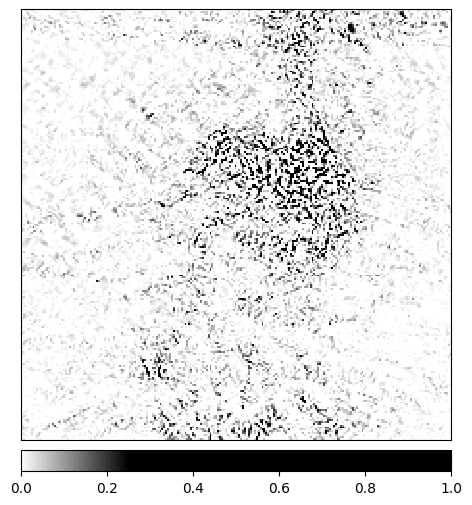

In [9]:
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

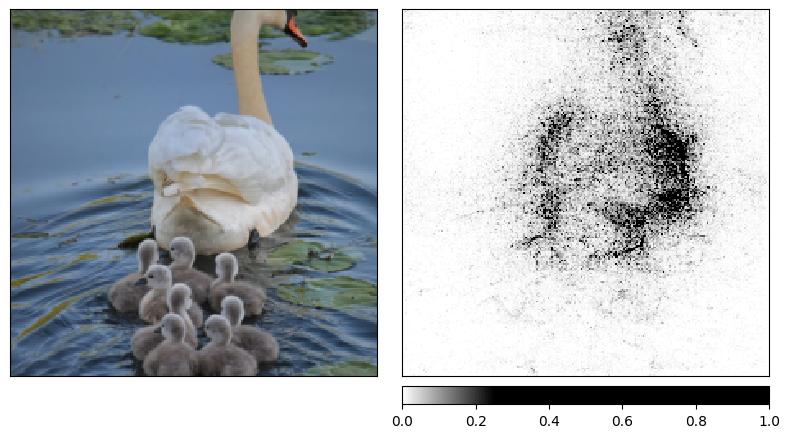

In [10]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)